In [ ]:
from google.colab import files    #for kaggle api
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"shreshthvishwakarma","key":"42f15efad923aad6c01628a948a9aedf"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d kritanjalijain/amazon-reviews
!unzip amazon-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews
License(s): CC0-1.0
 99% 1.28G/1.29G [00:08<00:00, 238MB/s]
100% 1.29G/1.29G [00:08<00:00, 165MB/s]
Archive:  amazon-reviews.zip
  inflating: amazon_review_polarity_csv.tgz  
  inflating: test.csv                
  inflating: train.csv               


In [19]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset, IterableDataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df_train = pd.read_csv("train.csv")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [ ]:
MAX_VOCAB_SIZE=30000      #to maintain the RAM constraints on colab
CHUNKSIZE=100000
MAX_LEN=256

In [ ]:
def clean_text(text):
    if text is None:
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)        #to keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()    #removing extra spaces
    return text

In [ ]:
print(clean_text("hello MY name is, shreshth. ew."))

hello my name is shreshth ew


In [ ]:
word_counts = Counter()
col_names = ['polarity', 'title', 'text']


for chunk in pd.read_csv('train.csv', chunksize=100000, names=col_names, header=None):

    chunk['full_text'] = chunk['title'].astype(str)+' '+chunk['text'].astype(str)
    chunk['full_text'] = chunk['full_text'].apply(clean_text)

    #counts the freq of each word
    for text in chunk['full_text']:
        word_counts.update(text.split())


In [12]:
len(word_counts.items())   #total no of different words in the dataset

2155753

In [13]:
vocab = {'<pad>': 0, '<unk>': 1}
idx = 2
for word, _ in word_counts.most_common(MAX_VOCAB_SIZE - 2):   #choosing only most frequent 30000 words for the vocabulary to manage the ram constraint
    vocab[word]=idx
    idx += 1

print(f"Vocabulary has {len(vocab)} words.")

Vocabulary has 30000 words.


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Path to GloVe file on Google Drive
glove_path = '/content/drive/MyDrive/glove.6B.100d.txt'

emb_index = {}    ##loading GloVe embeddings here

with open(glove_path, 'r', encoding='utf8') as f:

    for line in f:
        word, *vec = line.split()
        emb_index[word] = np.array(vec, dtype='float32')


print(f"Loaded {len(emb_index)} GloVe vectors into emb_index.")




Loaded 400000 GloVe vectors into emb_index.


In [16]:
embedding_matrix = np.zeros((len(vocab), 100), dtype='float32')    #words not found in Glove will remain as zero vectors in the final embedding_matrix

words_found = 0

for word, i in vocab.items():
    if word in emb_index:
        embedding_matrix[i] = emb_index[word]
        words_found += 1


print(f"Found {words_found}/{len(vocab)} words in GloVe embeddings.")

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

Found 27956/30000 words in GloVe embeddings.


In [17]:
#below function was written with ChatGPT
# Modified process_dataframe to yield individual samples from a chunk ---
def process_chunk_to_samples(chunk_df, vocab, max_len):
    """
    Processes a chunk dataframe and yields individual (input_tensor, label_tensor) pairs.
    """
    labels = chunk_df['polarity'].map({1: 0, 2: 1}).values
    chunk_df['full_text'] = chunk_df['title'].astype(str) + ' ' + chunk_df['text'].astype(str)
    chunk_df['full_text'] = chunk_df['full_text'].apply(clean_text)

    for i, text in enumerate(chunk_df['full_text']):
        tokens = text.split()
        tokens = tokens[:max_len]
        indexed_tokens = [vocab.get(word, vocab['<unk>']) for word in tokens]
        n_pads = max_len - len(indexed_tokens)
        padded_sequence = indexed_tokens + [vocab['<pad>']] * n_pads
        yield torch.tensor(padded_sequence, dtype=torch.long), torch.tensor(labels[i], dtype=torch.float32)


In [20]:
#below class object was written with refrence from ChatGPT as I dont know how to define 'Custom IterableDataset'
# Define a Custom IterableDataset for efficient chunking ---
class LargeTextDataset(IterableDataset):
    def __init__(self, file_path, col_names, chunksize, vocab, max_len):
        self.file_path = file_path
        self.col_names = col_names
        self.chunksize = chunksize
        self.vocab = vocab
        self.max_len = max_len

    def __iter__(self):
        # Create a new reader for each iterator (important for DataLoader's multi-worker support)
        # This ensures that if num_workers > 0, each worker gets its own file handle.
        csv_reader = pd.read_csv(
            self.file_path,
            chunksize=self.chunksize,
            names=self.col_names,
            header=None
        )
        for chunk_df in csv_reader:
            # process_chunk_to_samples yields individual (input, label) pairs
            for input_sample, label_sample in process_chunk_to_samples(chunk_df, self.vocab, self.max_len):
                yield input_sample, label_sample


In [21]:
train_dataset = LargeTextDataset('train.csv', col_names, CHUNKSIZE, vocab, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False, drop_last=True)


In [22]:
test_dataset = LargeTextDataset('test.csv', col_names, CHUNKSIZE, vocab, MAX_LEN)

test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, drop_last=True)




In [23]:
class RNNmodel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(embedding_matrix)
        self.embedding.weight.requires_grad = False
        self.rnn =nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2,output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        _, hidden = self.rnn(embedded)

        # Concatenate the forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        # hidden shape: [batch size, hidden dim * 2]

        return self.fc(hidden)



In [24]:
class LSTMmodel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(embedding_matrix)
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True, dropout=0.5 if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        _, (hidden, _) = self.lstm(embedded)      #LSTM returns output, (final hidden state, final cell state)

        # Concatenate the forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        return self.fc(hidden)

In [32]:
def evaluate_model(model, loader, criterion):
    model.eval()
    preds, labels = [], []
    total_loss = 0
    num_batches = 0         #initializing a counter for batches

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            num_batches += 1

            preds = torch.round(torch.sigmoid(outputs))
            preds.extend(preds.cpu().numpy())
            labels.extend(labels.cpu().numpy())


    if num_batches>0:
      avg_loss = total_loss/num_batches
    else:
      avg_loss = 0

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)


    return avg_loss, acc, f1, labels, preds

In [26]:
#RNN
model_rnn = RNNmodel(vocab_size=len(vocab), embedding_dim=100, hidden_dim=128, output_dim=1, n_layers=2, embedding_matrix=embedding_matrix).to(device)

criterion_rnn = nn.BCEWithLogitsLoss()
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

#training
for epoch in range(3):
    model_rnn.train()
    total_loss_rnn = 0
    num_batches_rnn = 0     #Counting batches for average loss calculations

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer_rnn.zero_grad()
        outputs = model_rnn(inputs).squeeze(1)
        loss = criterion_rnn(outputs, labels)
        loss.backward()
        optimizer_rnn.step()

        total_loss_rnn += loss.item()
        num_batches_rnn += 1

    if num_batches_rnn>0:
      avg_train_loss_rnn = total_loss_rnn/num_batches_rnn
    else:
      avg_train_loss_rnn = 0


    print(f"\nEpoch: {epoch+1} Train Loss: {avg_train_loss_rnn:.6f}")



Epoch: 1 Train Loss: 0.383803

Epoch: 2 Train Loss: 0.388839

Epoch: 3 Train Loss: 0.393208


In [28]:
#LSTM
model_lstm = LSTMmodel(vocab_size=len(vocab), embedding_dim=100,hidden_dim=128,output_dim=1, n_layers=2,embedding_matrix=embedding_matrix).to(device)
criterion_lstm=nn.BCEWithLogitsLoss()
optimizer_lstm=torch.optim.Adam(model_lstm.parameters(), lr=0.001)

#training loop
for epoch in range(3):
    model_lstm.train()
    total_loss_lstm = 0
    num_batches_lstm = 0


    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer_lstm.zero_grad()
        outputs = model_lstm(inputs).squeeze(1)
        loss = criterion_lstm(outputs, labels)
        loss.backward()
        optimizer_lstm.step()

        total_loss_lstm += loss.item()
        num_batches_lstm += 1

    if num_batches_lstm>0:
      avg_train_loss_lstm = total_loss_lstm/ num_batches_lstm
    else:
      avg_train_loss_lstm = 0


    print(f"\nEpoch: {epoch+1} Train Loss: {avg_train_loss_lstm:.6f}")



Epoch: 1 Train Loss: 0.212152

Epoch: 2 Train Loss: 0.146394

Epoch: 3 Train Loss: 0.131615


Test Accuracy (RNN): 82.355604%
Test F1-Score (RNN): 0.826186


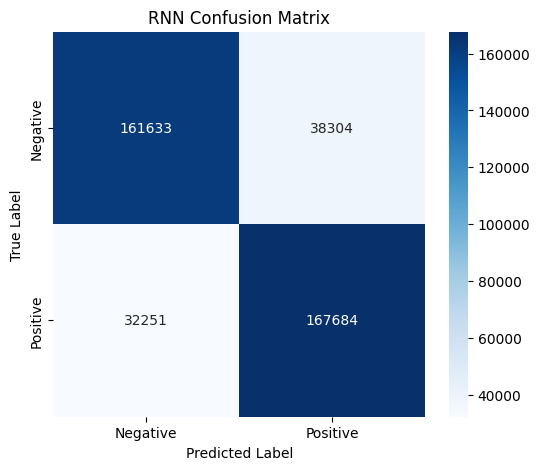

In [35]:
#Evaluation
_, acc_rnn, f1_rnn, true_labels_rnn, preds_rnn = evaluate_model(model_rnn, test_loader, criterion_rnn)
print(f"Test Accuracy (RNN): {acc_rnn*100:.6f}%")
print(f"Test F1-Score (RNN): {f1_rnn:.6f}")

# Plot Confusion Matrix    (ChatGPT)
cm_rnn = confusion_matrix(true_labels_rnn, preds_rnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RNN Confusion Matrix')
plt.show()

Test Accuracy (LSTM): 94.999650%
Test F1 Score (LSTM): 0.950726


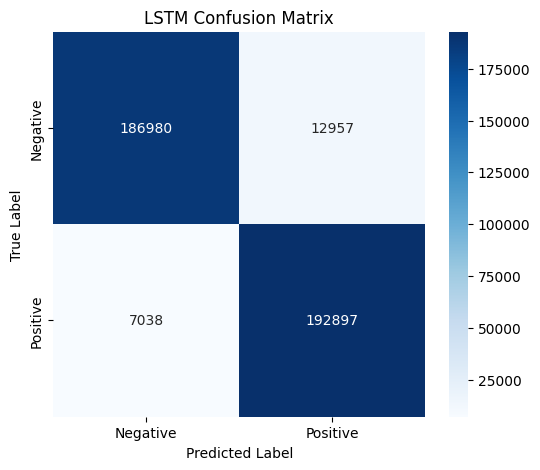

In [36]:
# Evaluation
_, acc_lstm, f1_lstm, true_labels_lstm, preds_lstm = evaluate_model(model_lstm, test_loader, criterion_lstm)
print(f"Test Accuracy (LSTM): {acc_lstm*100:.6f}%")
print(f"Test F1 Score (LSTM): {f1_lstm:.6f}")

# Plot Confusion Matrix
cm_lstm = confusion_matrix(true_labels_lstm, preds_lstm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LSTM Confusion Matrix')
plt.show()